In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F

import time, pathlib, os

## 2D dataset

In [2]:
# # The two-dimensional domain of the fit.....
# ########https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/#########
# x1min, x1max, nx1 = -5, 6, 75
# x2min, x2max, nx2 = -3, 7, 75
# x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
# X1, X2 = np.meshgrid(x1, x2)

# # Our function to fit is going to be a sum of two-dimensional Gaussians
# def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
#     return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

# # A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
# gprms = [(0, 2, 2.5, 5.4, 1.5),
#          (-1, 4, 6, 2.5, 1.8),
#          (-3, -0.5, 1, 2, 4),
#          (3, 0.5, 2, 1, 5)
#         ]

# # Standard deviation of normally-distributed noise to add in generating
# # our test function to fit.
# # The function to be fit is Z.
# Y = np.zeros(X1.shape)
# for p in gprms:
#     Y += gaussian(X1, X2, *p)
# ### Adding noise to the data
# # noise_sigma = 0.1
# # Z += noise_sigma * np.random.randn(*Z.shape)

# ####Scaling the data to range -1,1
# X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
# X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
# Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
# Y = -Y

# x1 = X1.reshape(-1)
# x2 = X2.reshape(-1)

# xx = torch.Tensor(np.c_[x1, x2])
# yy = torch.Tensor(Y.reshape(-1,1))

In [3]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
# X1 = np.linspace(-2.5, 0, num_points)
X2 = np.linspace(-2, 4, num_points)
# X2 = np.linspace(-2, 2, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = -Y

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

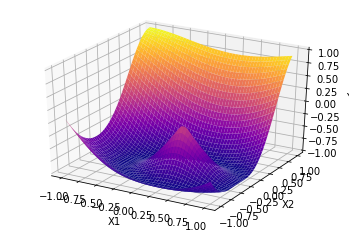

In [4]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [5]:
from classes import *

In [12]:
# network_seed = 147  # 147 #258 # 369
network_seeds = [147, 258, 369]
# network_seeds = [369]

EPOCHS = 5000

# actf = nn.LeakyReLU
actf = nn.ELU

learning_rate = 0.005
lambda_ = 0.5

criterion = nn.MSELoss()

## Linear Regression

In [7]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

epoch_times = []
stat_per_seed = []
# images = []
for network_seed in network_seeds:
    torch.manual_seed(network_seed)

    linNet = nn.Linear(2,1)
    optimizer = torch.optim.Adam(linNet.parameters(), lr=learning_rate)

    for epoch in range(EPOCHS):
        start = time.time()
        
        yout = linNet(xx)    
        loss = criterion(yout, yy)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        epoch_times.append(time.time()-start)
        if epoch%100 == 0 or epoch==EPOCHS-1:
            print(f'Epoch: {epoch}, Loss:{float(loss)}')
            ax.clear()
            ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
            ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
            ax2.clear()
            ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

            fig.canvas.draw()
            plt.pause(0.01)
    stat_per_seed.append(f'Epoch: {epoch}, Loss:{float(loss)}')
    
#     image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)\
#                         .reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     images.append(image_from_plot)
#     plt.savefig("./invex_out/comparision/cls_logistic.pdf", bbox_inches='tight')
plt.close()

Epoch: 0, Loss:0.7523080706596375
Epoch: 100, Loss:0.311083048582077
Epoch: 200, Loss:0.17846599221229553
Epoch: 300, Loss:0.1463988721370697
Epoch: 400, Loss:0.14051973819732666
Epoch: 500, Loss:0.13977690041065216
Epoch: 600, Loss:0.1397143006324768
Epoch: 700, Loss:0.13971081376075745
Epoch: 800, Loss:0.1397106945514679


TclError: invalid command name "pyimage10"

In [ ]:
for sps in stat_per_seed:
    print(sps)
print(np.mean(epoch_times), np.std(epoch_times))

# Convex NN

In [ ]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

epoch_times = []
stat_per_seed = []
# images = []
for network_seed in network_seeds:
    torch.manual_seed(network_seed)

    cvxNet = ConvexNN([2, 10, 10, 1], actf)
    optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

    for epoch in range(EPOCHS):
        start = time.time()
        
        yout = cvxNet(xx)    
        loss = criterion(yout, yy)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        epoch_times.append(time.time()-start)
        if epoch%100 == 0 or epoch==EPOCHS-1:
            print(f'Epoch: {epoch}, Loss:{float(loss)}')
            ax.clear()
            ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
            ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
            ax2.clear()
            ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

            fig.canvas.draw()
            plt.pause(0.01)
    stat_per_seed.append(f'Epoch: {epoch}, Loss:{float(loss)}')
plt.close()

In [ ]:
for sps in stat_per_seed:
    print(sps)
print(np.mean(epoch_times), np.std(epoch_times))

# Single Layer NN

In [ ]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

epoch_times = []
stat_per_seed = []
# images = []
for network_seed in network_seeds:
    torch.manual_seed(network_seed)

    mlpNet = nn.Sequential(nn.Linear(2,10),
                             actf(),
                             nn.Linear(10,10),
                             actf(),
                             nn.Linear(10,1),
                            )
    optimizer = torch.optim.Adam(mlpNet.parameters(), lr=learning_rate)

    for epoch in range(EPOCHS):
        start = time.time()
        
        yout = mlpNet(xx)    
        loss = criterion(yout, yy)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        epoch_times.append(time.time()-start)
        if epoch%100 == 0 or epoch==EPOCHS-1:
            print(f'Epoch: {epoch}, Loss:{float(loss)}')
            ax.clear()
            ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
            ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
            ax2.clear()
            ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

            fig.canvas.draw()
            plt.pause(0.01)
    stat_per_seed.append(f'Epoch: {epoch}, Loss:{float(loss)}')
plt.close()

In [ ]:
for sps in stat_per_seed:
    print(sps)
print(np.mean(epoch_times), np.std(epoch_times))

# Invex

In [8]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

In [9]:
class BasicInvexNet(nn.Module):
    
    def __init__(self, input_dim, net, lamda=1.):
        super().__init__()
        
        self.net = net
        self.center = nn.Parameter(torch.zeros(input_dim).unsqueeze(0))
        self.lamda = lamda
        self.X = None
        
        self.Y = None
        self.dydx_cent = None
        self.dydx = None
        
        self.gp = 0
        self.gclipper = 999
        
    def forward(self, x, hook=True):
#         self.weight_norm()
        self.X = x
        if not x.requires_grad:
            self.X = torch.autograd.Variable(x, requires_grad=True)
        
        self.Y = self.net(self.X)
        y = self.Y+0.
        if y.requires_grad and hook:
            y.register_hook(self.scale_gradient_back)
        return y
    
    def scale_gradient_back(self, grad):
        return torch.minimum(torch.maximum(grad, -self.gclipper), self.gclipper)
    
    def weight_norm(self):
        for child in get_children(self.net):
            if isinstance(child, nn.Linear):
                norm = torch.norm(child.weight.data, dim=1)
#                 print(norm)
                indx = torch.nonzero(norm>5., as_tuple=False).t()[0]
                if len(indx)==0: continue
#                 print(indx)
#                 print("Weight")
#                 print(child.weight.data[indx].shape)
                child.weight.data[indx] *= 3/(norm[indx].reshape(-1,1))
        
    def get_dydx_cent(self):
        self.dydx_cent = (self.center-self.X.data)+torch.randn_like(self.X.data)*1e-8
        self.dydx_cent = self.dydx_cent/torch.norm(self.dydx_cent, p=2, dim=1, keepdim=True)
        return self.dydx_cent
    
    def get_dydx(self):
        self.dydx = torch.autograd.grad(outputs=self.Y, inputs=self.X,
                                    grad_outputs=torch.ones_like(self.Y),
                                    only_inputs=True, retain_graph=True, create_graph=True)[0]
        return self.dydx
    
    def smooth_l1(self, x, beta=1):
        mask = x<beta
        y = torch.empty_like(x)
        y[mask] = 0.5*(x[mask]**2)/beta
        y[~mask] = torch.abs(x[~mask])-0.5*beta
        return y
    
    def get_gradient_penalty(self):
        m = self.dydx.shape[0]
        ## gradient is projected in the direction of center (aka. minima/maxima)
        projected_grad = torch.bmm(self.dydx.view(m, 1, -1), self.dydx_cent.view(m, -1, 1)).view(-1, 1)
        
#         projected_grad[torch.isnan(projected_grad)] = 0.
        
        self.cond = projected_grad
        
#         a=-20
#         intolerables = torch.log(torch.exp(a*(self.cond-0.1))+1)/a
#         intolerables = torch.clamp(F.softplus(self.cond-0.1, beta=-20), -1, 1)
        intolerables = F.softplus(self.cond-0.1, beta=-20)

#         dydx_norm = torch.norm(self.dydx.data, p=2, dim=1, keepdim=True)
#         self.gp = 0.5*((intolerables*5)**2).mean()*self.lamda
        
        self.gp = (self.smooth_l1(intolerables*5)).mean()*self.lamda

        return self.gp
    
    def get_gradient_clipper(self):
        with torch.no_grad():
            cond = self.cond.data
            linear_mask = cond>0.14845
            a = 20.
            gclipper = -((1.05*(cond-1))**4)+1
            gclipper = torch.log(torch.exp(a*gclipper)+1)/a
            gc2 = 3*cond-0.0844560006
            gclipper[linear_mask] = gc2[linear_mask]
            self.gclipper = gclipper
        return self.gclipper

    def MSE_loss(self, diff):
        return 0.5*(diff**2).mean()
    
    def compute_penalty_and_clipper(self):
        self.get_dydx_cent()
        self.get_dydx()
        self.get_gradient_penalty()
        self.get_gradient_clipper()
        return

In [13]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)

epoch_times = []
stat_per_seed = []
for network_seed in network_seeds:
# for network_seed in [123]:
    torch.manual_seed(network_seed)
    net_lips = nn.Sequential(nn.Linear(2,10),
                             actf(),
                             nn.Linear(10,10),
                             actf(),
                             nn.Linear(10,1),
                            )
    binvxNet = BasicInvexNet(2, net_lips, lamda=lambda_)
    optimizer = torch.optim.Adam(binvxNet.parameters(), lr=learning_rate)

    for epoch in range(EPOCHS):
        start = time.time()
        
        yout = binvxNet(xx)    
        binvxNet.compute_penalty_and_clipper()
        
        loss = criterion(yout, yy) + binvxNet.gp

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        epoch_times.append(time.time()-start)
        if epoch%100 == 0 or epoch==EPOCHS-1:
            min_val = float(binvxNet.cond.min()) 
            print(f'Epoch: {epoch}, Loss:{float(loss)}, MinVal:{min_val}, gp: {float(binvxNet.gp)}')
            ax.clear()
            ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
            ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
            ax2.clear()
            ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

            fig.canvas.draw()
            plt.pause(0.01)
    stat_per_seed.append(f'Epoch: {epoch}, Loss:{float(loss)}, MinVal:{min_val}, gp: {float(binvxNet.gp)}')
plt.close()

Epoch: 0, Loss:0.8707913160324097, MinVal:-0.17999348044395447, gp: 0.11195218563079834
Epoch: 100, Loss:0.27228569984436035, MinVal:-0.19401423633098602, gp: 0.024939771741628647
Epoch: 200, Loss:0.1419149786233902, MinVal:-0.3737001121044159, gp: 0.0056243534199893475
Epoch: 300, Loss:0.04327893257141113, MinVal:0.006222546100616455, gp: 0.0019960589706897736
Epoch: 400, Loss:0.034429337829351425, MinVal:-0.03766784071922302, gp: 0.001383134862408042
Epoch: 500, Loss:0.03126101940870285, MinVal:0.03480398654937744, gp: 0.001358858193270862
Epoch: 600, Loss:0.03040291555225849, MinVal:0.059520453214645386, gp: 0.0012899432331323624
Epoch: 700, Loss:0.029697932302951813, MinVal:0.06434527039527893, gp: 0.0012571609113365412
Epoch: 800, Loss:0.028562232851982117, MinVal:0.058359742164611816, gp: 0.0012917352141812444
Epoch: 900, Loss:0.025475887581706047, MinVal:0.07512317597866058, gp: 0.0012630985584110022
Epoch: 1000, Loss:0.022187041118741035, MinVal:0.05396786332130432, gp: 0.00128

Epoch: 3700, Loss:0.015346955507993698, MinVal:0.07145988941192627, gp: 0.0013567882124334574
Epoch: 3800, Loss:0.01530509628355503, MinVal:0.0709911361336708, gp: 0.0013743768213316798
Epoch: 3900, Loss:0.015286548994481564, MinVal:0.07393746823072433, gp: 0.0012451914371922612
Epoch: 4000, Loss:0.015415867790579796, MinVal:0.06773117184638977, gp: 0.001469793263822794
Epoch: 4100, Loss:0.015281678177416325, MinVal:0.07730318605899811, gp: 0.0011136539978906512
Epoch: 4200, Loss:0.015260215848684311, MinVal:0.07276701927185059, gp: 0.001266308594495058
Epoch: 4300, Loss:0.015348177403211594, MinVal:0.08295703679323196, gp: 0.0009120608447119594
Epoch: 4400, Loss:0.015250450000166893, MinVal:0.06945224851369858, gp: 0.0013731243088841438
Epoch: 4500, Loss:0.015305311419069767, MinVal:0.0790809839963913, gp: 0.0010235580848529935
Epoch: 4600, Loss:0.01525080669671297, MinVal:0.07540705054998398, gp: 0.0011449577286839485
Epoch: 4700, Loss:0.015223570168018341, MinVal:0.06990664452314377

In [14]:
for sps in stat_per_seed:
    print(sps)
print(np.mean(epoch_times), np.std(epoch_times))

Epoch: 4999, Loss:0.015220782719552517, MinVal:0.07107916474342346, gp: 0.0011838121572509408
Epoch: 4999, Loss:0.015243611298501492, MinVal:0.06945657730102539, gp: 0.001290002721361816
Epoch: 4999, Loss:0.015461556613445282, MinVal:0.06522044539451599, gp: 0.0012055381666868925
0.006359085416793823 0.0010362957285401744
